本專案探討亞馬遜樂器評論(Amazon Musical Instruments Reviews)資料進行情感分類與分析，個別評論/回饋進行分類，並根據這些評論確定整體評分。內容包含句子分割成詞（Tokenization）、詞形還原（Lemmatization）、詞性標註（POS tagging）、TF-IDF（詞頻-逆文件頻率）權重、字雲（Word Cloud）等自然語言常見的處理方法。

最後，以常見的機器學習分類演算法進行模型選取，包含支持向量分類、隨機森林、羅吉斯迴歸等。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

In [4]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

In [5]:
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [6]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Instruments_Reviews.csv")

Mounted at /content/drive


#### **Shape of The Dataset**

In [7]:
data.shape

(10261, 9)

### Data Preprocessing

In [8]:
data.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


數據集中有兩個欄位存在遺失值：**`reviewText`** 和 **`reviewerName`**。我們關注 **`reviewText`**，客戶提供的評分和摘要會對模型產生影響（儘管遺失的行數較少）。可以用空字串來填補這些遺失值。

In [9]:
data.reviewText.fillna(value = "", inplace = True)

<ipython-input-9-5568c3251cb3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.reviewText.fillna(value = "", inplace = True)


In [11]:
data["reviews"] = data["reviewText"] + " " + data["summary"]
data.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

In [12]:
data.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","These strings are really quite good, but I wou..."
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


客戶給出的評分範圍為1到5分。此外，銷售的樂器平均分數為 4.48分。

客戶給出評分的百分比

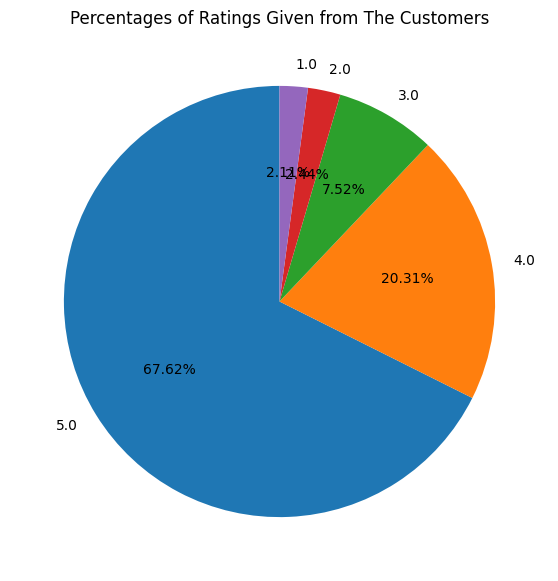

In [13]:
ratings_counts = data.overall.value_counts()
plt.figure(figsize=(7, 7))
plt.pie(ratings_counts, labels=ratings_counts.index, autopct="%1.2f%%", startangle=90, textprops={'fontsize': 10})
plt.title("Percentages of Ratings Given from The Customers", loc="center")
plt.show()

從上述圓餅圖可以看出，大多數在 Amazon 上銷售的樂器獲得了 5 的完美評分。如果我們將評分高於 3 視為正面，評分等於 3 視為中立，評分低於 3 視為負面，數據集中負面評論的數量相對較少。

由於數據集未包含任何預測目標。根據先前的說明，我們將根據每一行的評分來分類情感標籤：評分大於 3.0 的產品標記為 `正面` (Positive Label)，評分等於 3.0 的標記為 `中立` (Neutral Label)，否則標記為 `負面` (Negative Label)。

In [14]:
def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label


data["sentiment"] = data.apply(Labelling, axis = 1)

Text(0, 0.5, 'Amount of Sentiments')

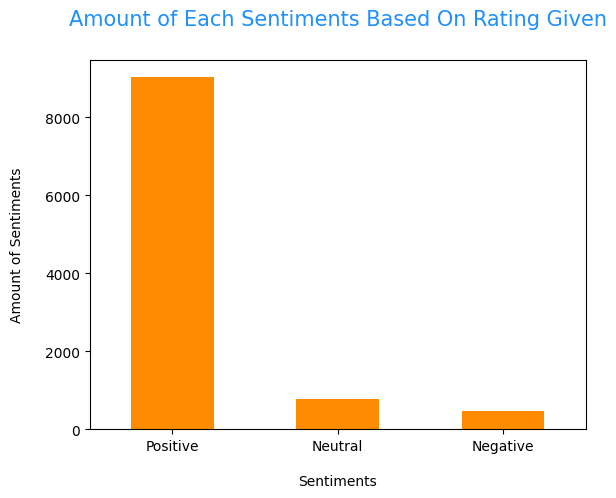

In [15]:
data["sentiment"].value_counts().plot(kind = "bar", color = "darkorange")
plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "dodgerblue", pad = 25)
plt.xlabel("Sentiments", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", fontsize = 10, labelpad = 15)

### Text Preprocessing

將文本轉換為小寫，確保大小寫不影響分析，例如 Good 和 good 被視為相同單詞。`str.maketrans`，會將標點符號替換為空格（防止單詞黏在一起）。移除 URL 網址、移除換行符號、移除數字。

In [16]:
def Text_Cleaning(Text):
  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Remove possible links
  Text = re.sub('https?://\S+|www\.\S+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

定義停用詞 (stopwords)

- nltk.corpus.stopwords.words("english") 取得 NLTK 內建的英文停用詞（例如 "the", "is", "and"）。

- set(["not"]) 從停用詞中 移除 "not"，因為在情感分析中，"not" 可能影響句子意義（如 "not bad" 和 "bad" 意思不同）。

- Lemmatizer: WordNetLemmatizer() 負責詞形還原（Lemmatization），將單詞轉換為詞根形式（如 running → run）。

In [17]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))

In [18]:
data["reviews"] = data["reviews"].apply(lambda Text: Text_Cleaning(Text))


In [19]:
data["reviews"] = data["reviews"].apply(lambda Text: Text_Processing(Text))

#### Exploratory Data Analysis

In [20]:
data.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sou...,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized ...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwis...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop ...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio fil...,Positive


情感分析中，評論(reviews) 對於模型相當重要，因此我們應該將其作為特徵(feature)。利用這個特徵，我們的目標是預測評論所屬的情感分類。

##### **極性(Polarity)**
極性是文本的情感傾向，通常範圍在 `[-1, 1]` 之間：

- 正數（>0） 表示 正面情感（如 "This product is amazing!"）。
- 0 表示 中立情感（如 "This is a product."）。
- 負數（<0） 表示 負面情感（如 "The product is terrible!"）。

In [21]:
# 計算每條評論的極性並新增到數據集
data["polarity"] = data["reviews"].apply(lambda x: TextBlob(x).sentiment.polarity)

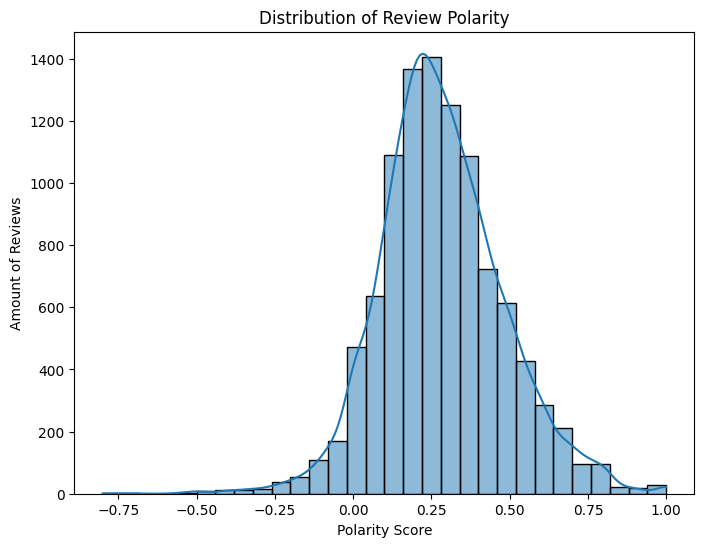

In [22]:
plt.figure(figsize=(8,6))
sns.histplot(data["polarity"], bins=30, kde=True)
plt.xlabel("Polarity Score")
plt.ylabel("Amount of Reviews")
plt.title("Distribution of Review Polarity")
plt.show()

極性為負的評論範圍為 `[-1, 0)`，中立評論為 `0.0`，而極性為正的評論範圍則為 `(0, 1]`。

從上方的直方圖可以看出，大部分評論的情感分佈偏向正面，這與我們之前的分析結果一致。從統計角度來看，這個直方圖顯示出數據呈近似常態分佈。

結論：評論的情感分佈與直方圖相符，證明數據集中正面評論佔多數。

#### 評論長度（Review Length）

In [23]:
data["length"] = data["reviews"].astype(str).apply(len)

Text(0, 0.5, 'Amount of Reviews')

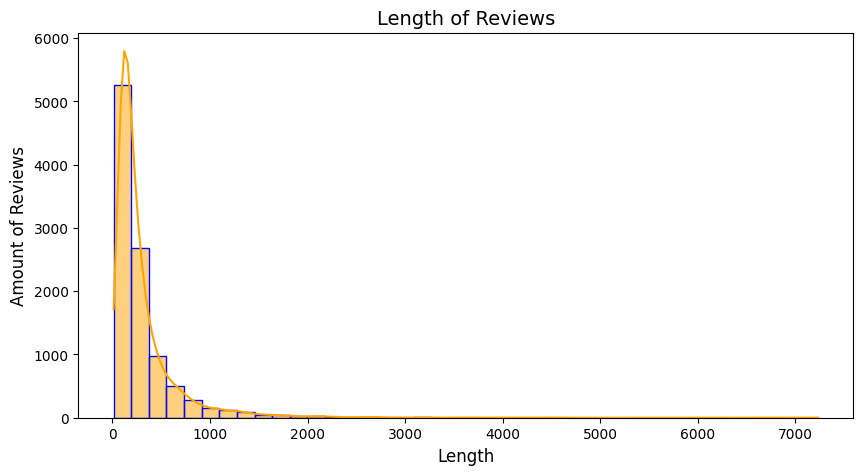

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(data["length"], bins=40, kde=True, color="orange", edgecolor="blue")

plt.title("Length of Reviews" , fontsize=14)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Amount of Reviews", fontsize=12)

根據上面的直方圖，我們知道評論的文字長度約在 0 到 1000 個字元之間。

- 正偏態（Positive Skewness）: 分佈向右偏移（Right-skewed），表示大部分的評論較短，而長評論較少。
- 這說明大多數使用者傾向於寫簡短評論，較少人會撰寫超過 1000 個字元的長評論。

#### 單詞數（Word Counts）

Text(0, 0.5, 'Amount of Reviews')

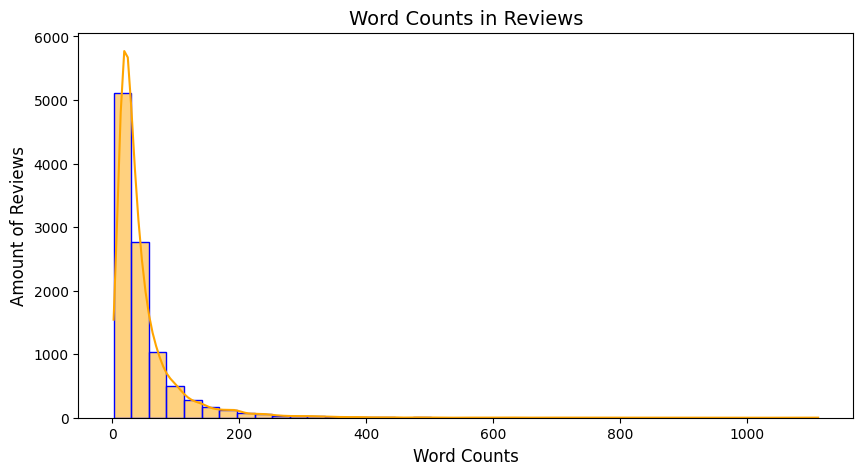

In [25]:
data["word_counts"] = data["reviews"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))

sns.histplot(data["word_counts"], bins=40, kde=True, color="orange", edgecolor="blue")
plt.title("Word Counts in Reviews", fontsize=14)
plt.xlabel("Word Counts", fontsize=12)
plt.ylabel("Amount of Reviews", fontsize=12)

從上圖我們可以推斷，大多數評論的單詞數都集中在 0 到 200 個單詞之間。就像之前的分析一樣，數據呈現右偏態（skewed right），表示大多數評論的單詞數比較少，長評論相對較少。

預處理的影響：由於文本預處理步驟（例如停用詞移除、標點符號清理等），評論的單詞數量可能比原始的評論要少，這樣也影響了最終的單詞數計算。

### N-Gram Analysis

N-Gram 分析是自然語言處理中一個重要的概念，用於捕捉文本中的詞語組合結構。在情感分析中，N-Grams 可以幫助我們了解哪些詞語經常一起出現，進而揭示某些模式或情感特徵。

In [26]:
Stopwords = list(set(nltk.corpus.stopwords.words("english")) - set(["not"]))  # example, adjust as needed

def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = Stopwords, ngram_range=(Gram, Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

Filter The DataFrame Based On Sentiments

In [27]:
# Use dropna() so the base DataFrame is not affected
Positive = data[data["sentiment"] == "Positive"].dropna()
Neutral = data[data["sentiment"] == "Neutral"].dropna()
Negative = data[data["sentiment"] == "Negative"].dropna()

Unigram of Reviews Based on Sentiments

In [28]:
Positive["reviews"]

,reviews
0,not much write exactly supposed filter pop sou...
1,product exactly quite affordable not realized ...
2,primary job device block breath would otherwis...
3,nice windscreen protects mxl mic prevents pop ...
4,pop filter great look performs like studio fil...
...,...
10256,great expected thank five star
10257,thinking trying nanoweb string bit put high pr...
10258,tried coated string past including elixir neve...
10259,well made elixir developed taylor guitar strin...


<ipython-input-29-0552d5f39020>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Unigram, palette="Greens_d")


Text(0, 0.5, 'Top Words')

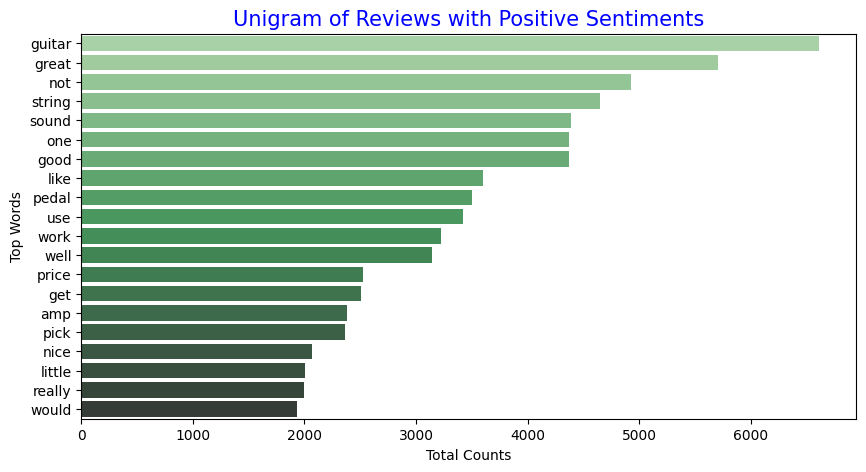

In [29]:
# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Unigram, palette="Greens_d")
plt.title("Unigram of Reviews with Positive Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)

<ipython-input-30-8039d3fb1af5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Unigram, palette="BuPu")


Text(0, 0.5, 'Top Words')

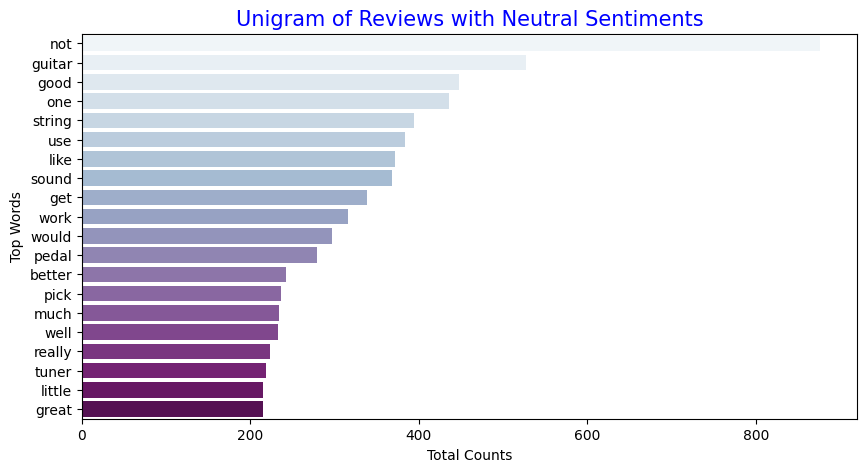

In [30]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Unigram, palette="BuPu")
plt.title("Unigram of Reviews with Neutral Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)

<ipython-input-31-f40758b175d8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Unigram, palette="OrRd")


Text(0, 0.5, 'Top Words')

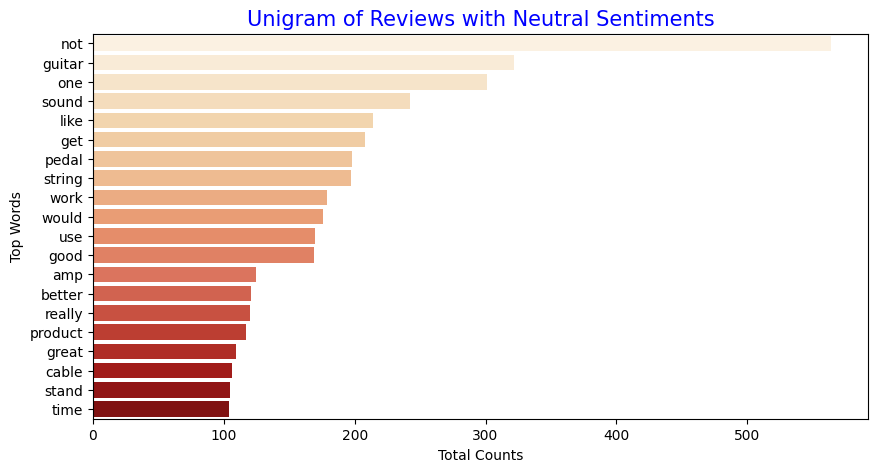

In [31]:
# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Unigram, palette="OrRd")
plt.title("Unigram of Reviews with Neutral Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)

這些單字組合（unigrams）並非十分準確，因為我們可以清楚地看到，即使是在正面情感的評論中，最常見的單字組合是「guitar」（吉他），這是一個具體物品的名稱。雖然從這裡我們可以知道最常購買的商品可能是吉他或與之相關的物品，但這樣的分析無法提供更精確的情感描述。我們應該嘗試分析雙字組合（bigrams），看看它能如何更準確地描述每個情感。

<ipython-input-32-69cc4f6b2728>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Bigram, palette="RdBu")


Text(0, 0.5, 'Top Words')

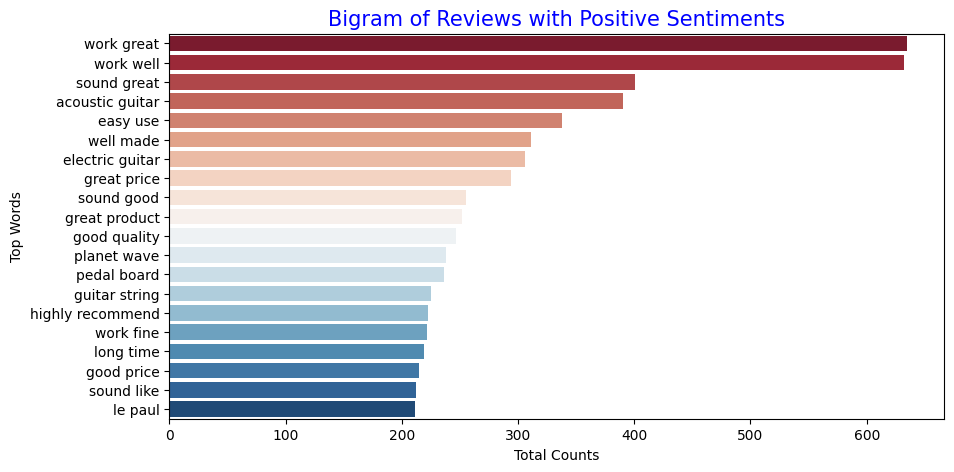

In [32]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Bigram, palette="RdBu")
plt.title("Bigram of Reviews with Positive Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)


<ipython-input-33-2629b15b5fcc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Bigram, palette="RdYlGn")


Text(0, 0.5, 'Top Words')

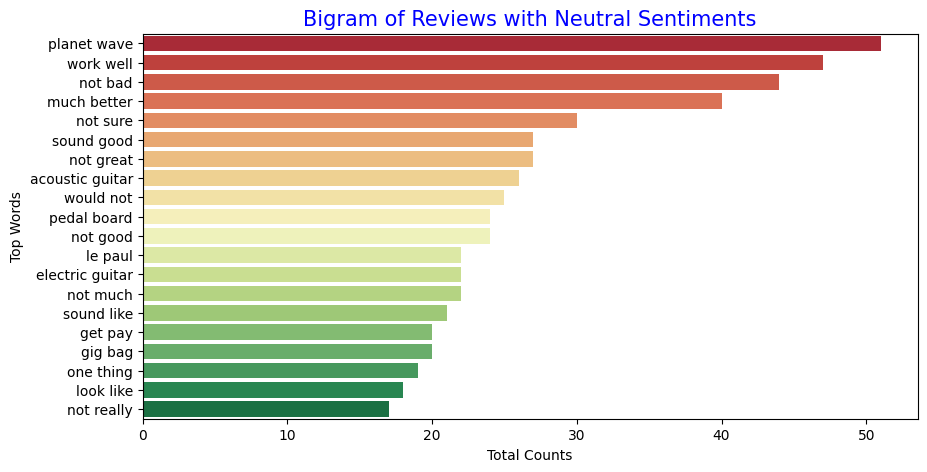

In [33]:
# Finding Bigram
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Bigram, palette="RdYlGn")
plt.title("Bigram of Reviews with Neutral Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)


<ipython-input-34-cc7776504828>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Bigram, palette="YlGnBu")


Text(0, 0.5, 'Top Words')

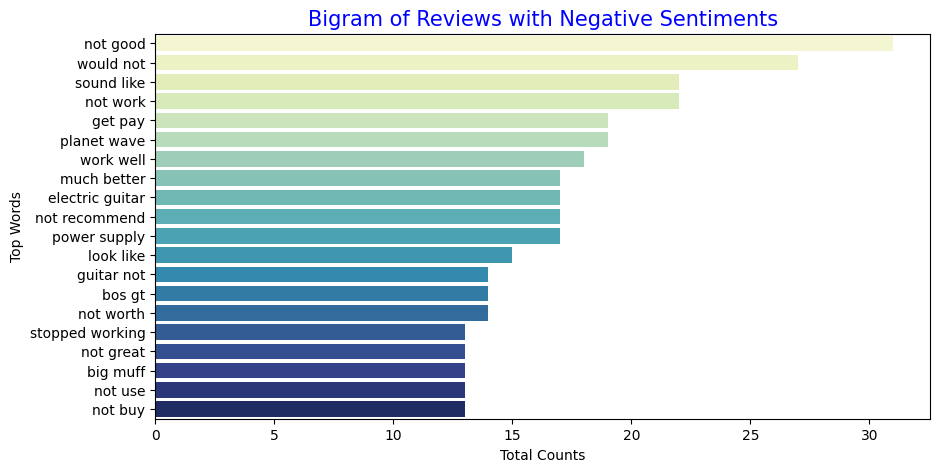

In [34]:
# Finding Bigram
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Bigram, palette="YlGnBu")
plt.title("Bigram of Reviews with Negative Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)

### Trigram of Reviews Based On Sentiments

<ipython-input-35-7037793fb3e5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Trigram, palette="Paired")


Text(0, 0.5, 'Top Words')

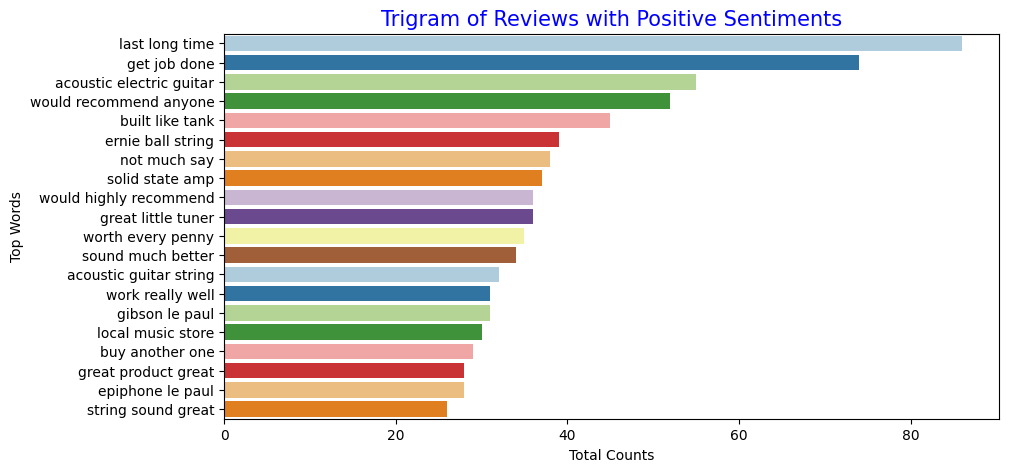

In [35]:
# Finding Trigram
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Trigram, palette="Paired")
plt.title("Trigram of Reviews with Positive Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)

<ipython-input-36-4465b1828855>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Trigram, palette="Paired")


Text(0, 0.5, 'Top Words')

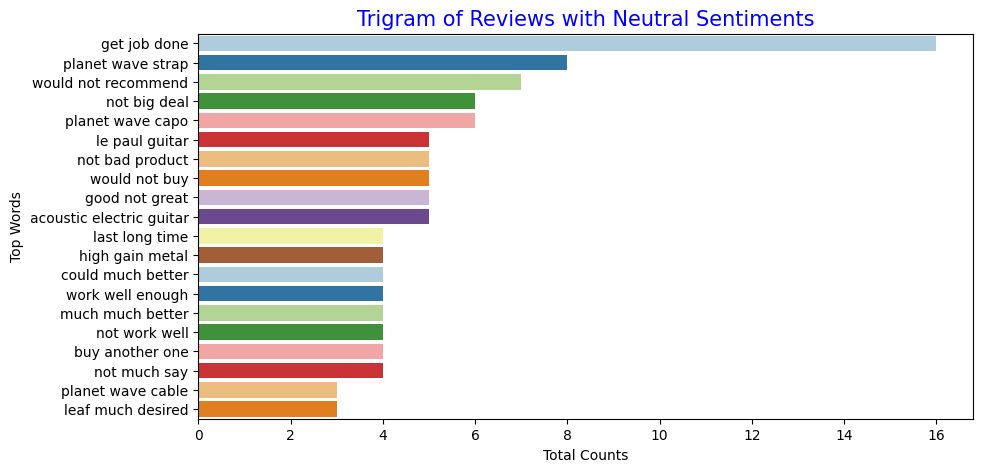

In [36]:
# Finding Trigram
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Trigram, palette="Paired")
plt.title("Trigram of Reviews with Neutral Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)

<ipython-input-37-1ceb5ff15d3b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Counts", y="Words", data=Trigram, palette="Paired")


Text(0, 0.5, 'Top Words')

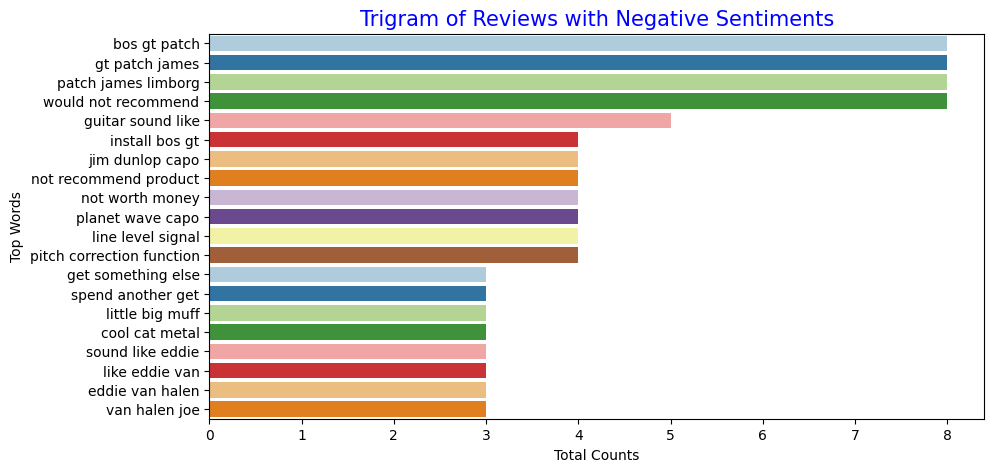

In [37]:
# Finding Trigram
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Counts", y="Words", data=Trigram, palette="Paired")
plt.title("Trigram of Reviews with Negative Sentiments", fontsize=15, color="blue", loc="center")
plt.xlabel("Total Counts", fontsize=10)
plt.ylabel("Top Words", fontsize=10)

我們可以說，三字組合（trigrams）略微優於雙字組合（bigrams）來描述每個情感，儘管負面三字組合確實揭示了很多關於不良產品的訓息，這些可以從上述的頂部詞彙中推測出來。從 N-Gram 分析中，我們還能看到，選擇不將「not」從停用詞中移除如何影響我們的數據，因為我們保留了否定語句的含義。

### Word Clouds

Word Clouds（文字雲）是一種非常直觀的數據視覺化方式，用來展示文本中出現頻率較高的單詞。字體較大的單詞表示在文本中出現的頻率較高，這能幫助我們快速理解文本中的關鍵概念或熱門詞彙。在情感分析中，文字雲可以幫助我們了解哪些詞彙在正面或負面情感中最為常見。

Word Cloud of Reviews with Positive Sentiments

(np.float64(-0.5), np.float64(2499.5), np.float64(1499.5), np.float64(-0.5))

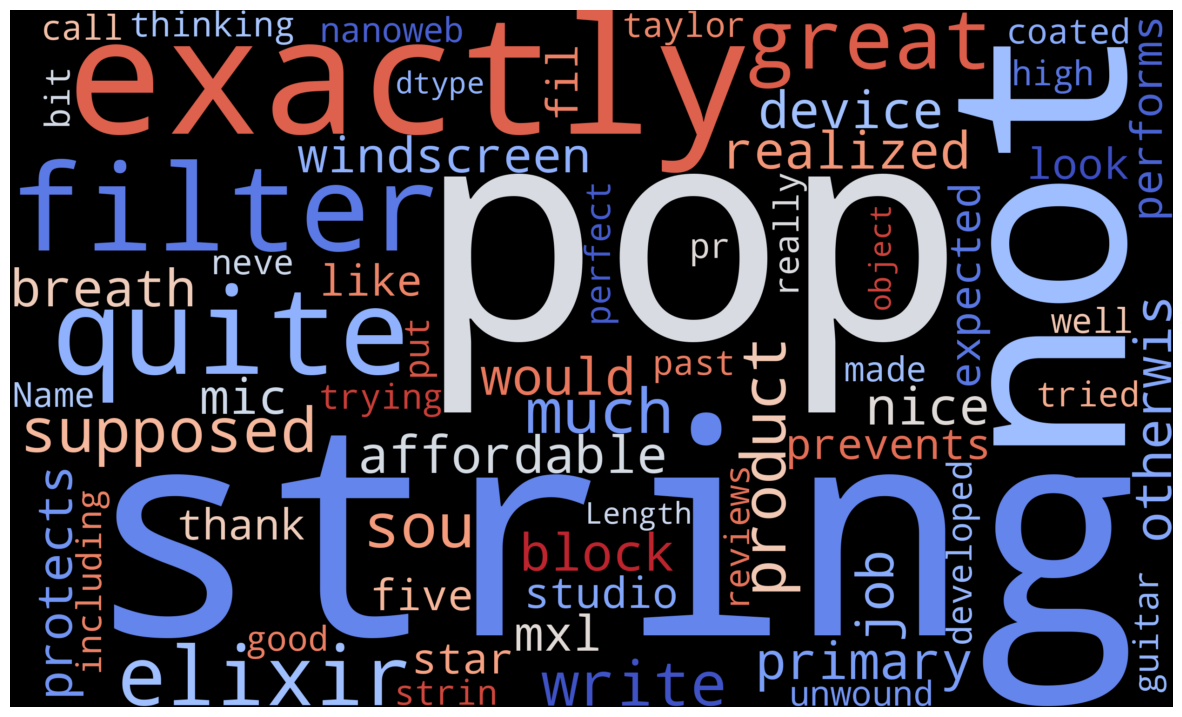

In [38]:
wordCloud = WordCloud(
    max_words = 70,
    width = 2500,
    height = 1500,
    stopwords = Stopwords,
    background_color = "black",
    colormap = "coolwarm"
).generate(str(Positive["reviews"]))

plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")

Word Cloud of Reviews with Neutral Sentiments

(np.float64(-0.5), np.float64(2499.5), np.float64(1499.5), np.float64(-0.5))

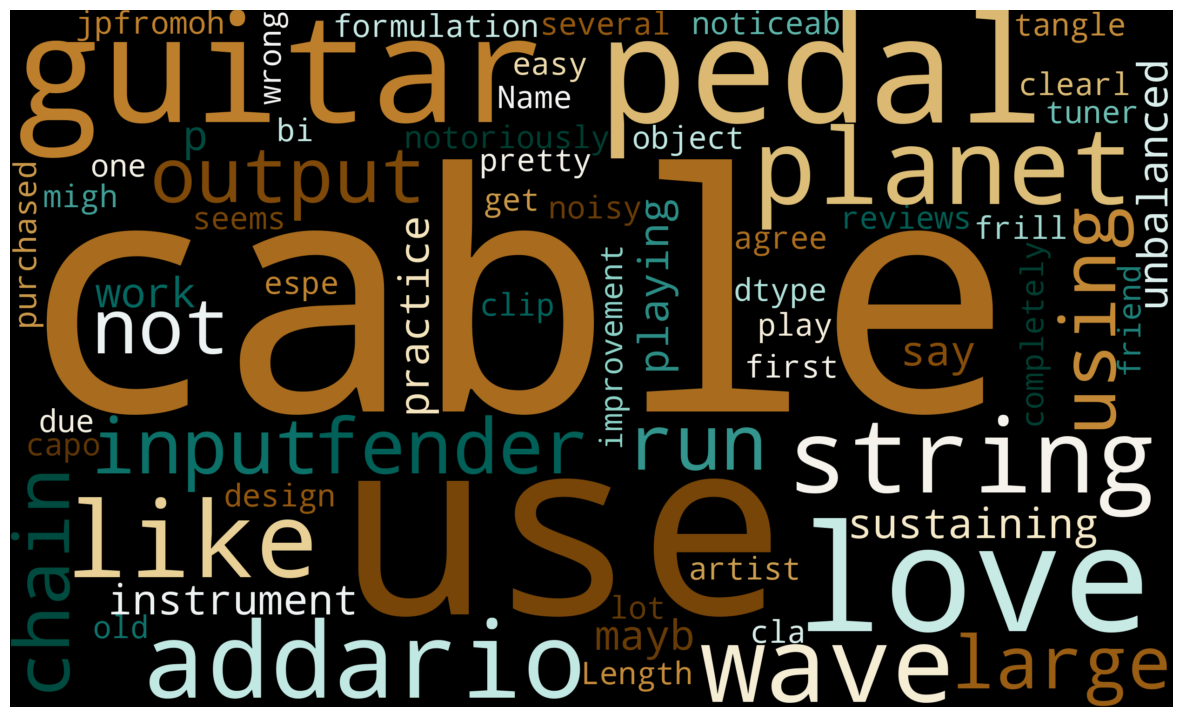

In [39]:
wordCloud = WordCloud(
    max_words = 70,
    width = 2500,
    height = 1500,
    stopwords = Stopwords,
    background_color = "black",
    colormap = "BrBG"
).generate(str(Neutral["reviews"]))

plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")

Word Cloud of Reviews with Negative Sentiments

(np.float64(-0.5), np.float64(2499.5), np.float64(1499.5), np.float64(-0.5))

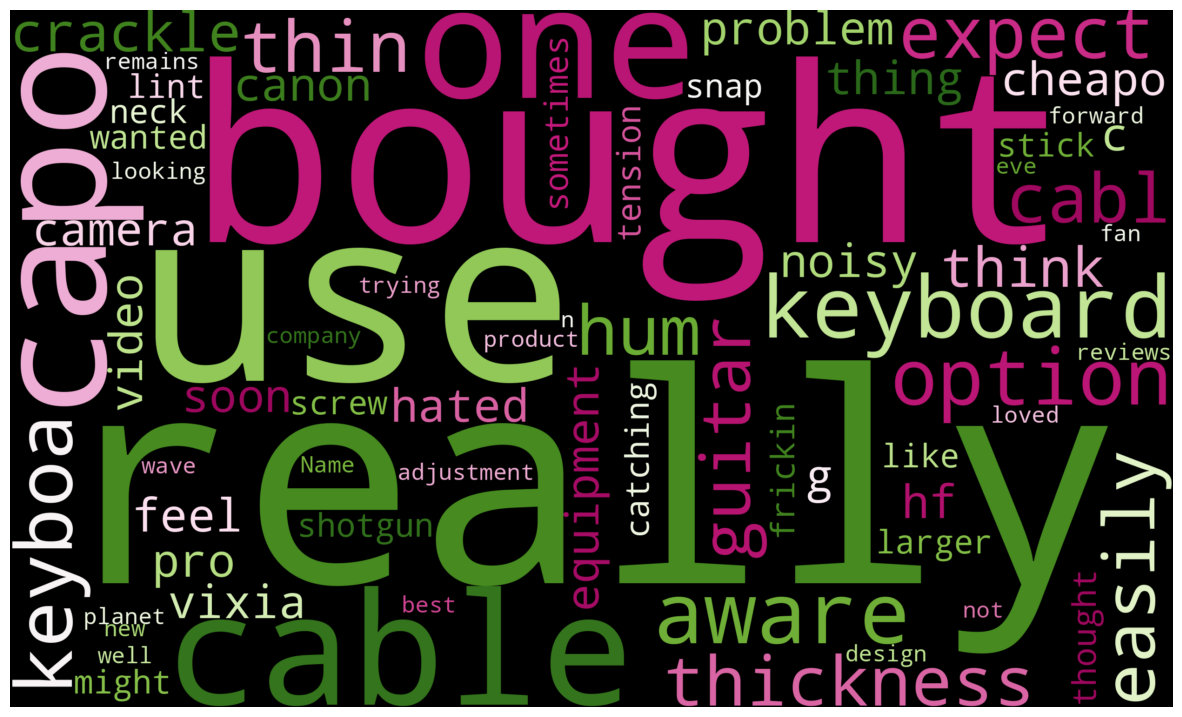

In [40]:
wordCloud = WordCloud(
    max_words = 70,
    width = 2500,
    height = 1500,
    stopwords = Stopwords,
    background_color = "black",
    colormap = "PiYG"
).generate(str(Negative["reviews"]))

plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")

### Feature Engineering

Encoding Our Target Variable

In [41]:
Encoder = LabelEncoder()
data["sentiment"] = Encoder.fit_transform(data["sentiment"])


data["sentiment"].value_counts()

,count
sentiment,
2,9022
1,772
0,467


標籤 Positive (正向) 被編碼為 2，Neutral (中立) 為 1，Negative (負向) 為 0。
我們需要衡量每個單詞在整篇評論中的重要性，賦予它們權重。
我們可以使用 TF-IDF (詞頻-逆文檔頻率) 向量化器。

TF-IDF (Term Frequency - Inverse Document Frequency) 是一種常用的文本向量化方法，用來衡量每個詞語在文檔中的重要性。它結合了詞頻（TF）和逆向文檔頻率（IDF），能夠將那些在文本中頻繁出現但在整個語料庫中並不常見的詞語賦予較高的權重，這樣能幫助模型更好地識別具有區分性的詞語。

In [42]:
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(data["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [43]:
y = data["sentiment"]

我們將評論轉換為使用 TF-IDF 向量化器的 7000 個最常見的雙詞組（bigram）詞語。數據有些不平衡，與正面情感相比，中性和負面情感的數量非常少。在進入建模過程之前，我們需要對數據集進行平衡處理。

重新取樣我們的數據集

對於不平衡的數據集，有許多方法可以進行重新取（resampling）。例如 SMOTE 和自助法（Bootstrap Method）。我們將使用 SMOTE（合成少數類別過採樣技術，Synthetic Minority Oversampling Technique），它會隨機生成我們少數類別數據的新的副本來平衡數據集。

In [44]:
Counter(y)

Counter({2: 9022, 1: 772, 0: 467})

In [45]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [46]:
Counter(y_final)

Counter({2: 9022, 1: 9022, 0: 9022})

將數據集按 75:25 的比例分割，分別用於訓練集和測試集。

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

### Model Selection and Evaluation

我們需要嘗試所有可用的分類模型，並通過混淆矩陣（Confusion Matrix）和 F1 分數（F1 Score）來找出最佳模型，首先使用交叉驗證技術（cross-validation）來找出最佳的模型。

In [48]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.8200947706277486
Logistic Regression Test Accuracy: 0.8819802942387887
SVC Test Accuracy: 0.8805184008381876
Random Forest Test Accuracy: 0.8783746258429803
Naive Bayes Test Accuracy: 0.8097643356470805
K-Neighbors Test Accuracy: 0.8662914182567747


由上述六個模型準確率可以看出，Logistic 和 SVM的模型表現皆有超過88%的準確率。

Hyperparameter Tuning

In [49]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l2']}
grid_search = GridSearchCV(estimator=LogisticRegression(solver='lbfgs', random_state=42),
                           param_grid=Param, scoring="accuracy", cv=10, verbose=0, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 94.92 %
Best Parameters: {'C': np.float64(10000.0), 'penalty': 'l2'}


使用Logistic Regression Model

In [50]:
Classifier = LogisticRegression(random_state = 42, C = np.float64(10000.0), penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

測試集資料準確率達95.42%

In [51]:
accuracy_score(y_test, Prediction)

0.9537461208807448

In [52]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)

In [53]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Greens):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


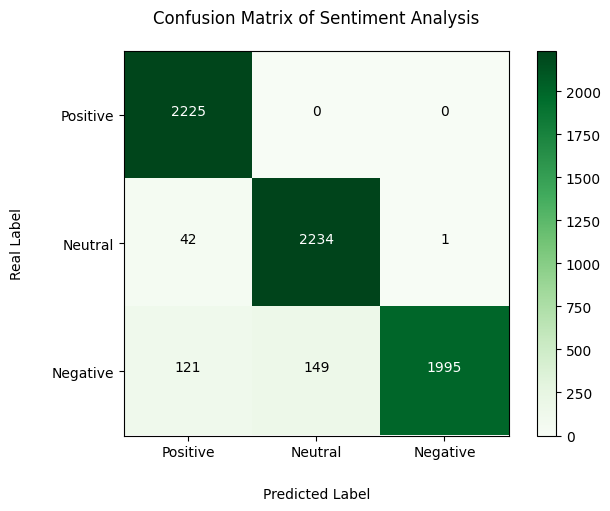

In [54]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")

In [55]:
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2225
           1       0.94      0.98      0.96      2277
           2       1.00      0.88      0.94      2265

    accuracy                           0.95      6767
   macro avg       0.96      0.95      0.95      6767
weighted avg       0.96      0.95      0.95      6767



#### 精確率 (Precision)

- 正向情感 (類別 2) 的精確率最高 (1.00)，表示所有被分類為「正向」的評論幾乎都是正向的。

- 負向 (0) 和中立 (1) 的精確率也相當高，分別為 0.93 和 0.94。

#### 召回率 (Recall)

- 正向情感 (類別 2) 的召回率較低 (0.88)，表示有 12% 的正向評論被錯誤分類。

- 中立情感 (類別 1) 的召回率為 0.98，表示幾乎所有的中立評論都被正確分類。

- 負向情感 (類別 0) 召回率最高 (1.00)，表示所有真正的「負向」評論都被正確分類。

#### F1-score

- 三個類別的 F1-score 都在 0.94~0.96 之間，表示模型整體表現良好。

- 正向情感 (類別 2) 的 F1-score 為 0.94，主要因為召回率較低 (0.88)，導致分數下降。

#### 結論

- 整體模型表現良好，準確率 95%，大部分評論能被正確分類。

- 負向與中立情感的召回率較高，表示模型能有效識別這兩類情感。

- 正向情感的召回率 (0.88) 相對較低，可能有部分正向評論被錯誤分類，需要進一步調整模型，如：

    - 調整權重 (class_weight) 以提升模型對正向評論的學習能力。

    - 嘗試不同的特徵選擇方法，例如 TF-IDF、詞嵌入 (word embeddings)。

    - 使用更複雜的模型，如神經網路 (Neural Networks) 或 BERT 等 NLP 模型。